In [1]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import pandas as pd

In [2]:
bd.__version__ >= (4, 0, 'DEV7'), bi.__version__ >= (0, 9, 'DEV4'), bc.__version__ >= (2, 0, 'DEV2')

(True, True, True)

In [3]:
bd.projects.set_current("fresh-start")

In [4]:
if "mobility" in bd.databases:
    del bd.databases['mobility']

if "biosphere" in bd.databases:
    del bd.databases['biosphere']

In [5]:
db = bd.Database("mobility")
db.register()

biosphere = bd.Database("biosphere")
biosphere.register()

In [6]:
data = {
    'code': 'bike',
    'name': 'bike production',
    'location': 'NO',
    'unit': 'bike'
}

bike = db.new_activity(**data)
bike.save()

In [7]:
data = {
    'code': 'CF',
    'name': 'carbon fibre',
    'unit': 'kilogram',
    'location': 'CN'
}
      # here you are creating a dictionary and then feeding with the next line
cf = db.new_activity(**data)
cf.save()

In [8]:
ng = db.new_activity(
    name="Nat Gas", 
    code='ng', 
    location='NO', 
    unit='MJ'
)
       # these are arguments into a function
ng.save()

In [9]:
co2 = biosphere.new_activity(
    name="Carbon Dioxide", 
    code='co2', 
    categories=('air',),
    type='emission',
)
         # before the default type was process
co2.save()

In [10]:
# create edges
bike.new_exchange(
    amount=2.5, 
    type='technosphere',
    input=cf
).save()

In [11]:
list(db)

['carbon fibre' (kilogram, CN, None),
 'Nat Gas' (MJ, NO, None),
 'bike production' (bike, NO, None)]

In [12]:
cf.new_exchange(
    amount=237.3,  # plus 58 kWh of electricity, in ecoinvent 3.8 
    uncertainty_type=5, 
    minimum=200, 
    maximum=300, 
    type='technosphere',
    input=ng,
).save()

In [13]:
cf.new_exchange(
    amount=26.6, 
    uncertainty_type=5, 
    minimum=26,
    maximum=27.2, 
    type='biosphere',
    input=co2,
).save()

In [14]:
ipcc = bd.Method(('IPCC',))
ipcc.write([
    (co2.key, {'amount': 1, 'uncertainty_type': 3, 'loc': 1, 'scale': 0.05}),   # uncertainty 3: gaussian
])

In [15]:
import bw2calc as bc

In [16]:
lca = bc.LCA(
    {bike: 1}, # Func unit is one bike
    ('IPCC',), # Method
    use_distributions=True,
    seed_override=None
)
lca.lci()
lca.lcia()

In [17]:
df = pd.DataFrame([
    {
        'score': lca.score, 
        'inv': lca.inventory.sum(), 
        # 'heat': lca.technosphere_matrix[lca.dicts.product[ng.id], lca.dicts.activity[cf.id]],
        'char': lca.characterization_matrix.sum()
    } for _, _ in zip(lca, range(1000))
])
df

,score,inv,char
0,64.208476,67.903405,0.945586
1,68.271769,66.888253,1.020684
2,67.864463,65.996759,1.028300
3,66.559598,65.477416,1.016528
4,61.274823,66.483227,0.921658
...,...,...,...
995,64.539491,67.041718,0.962677
996,69.288824,67.229862,1.030626
997,66.629898,66.247060,1.005779
998,64.770079,67.283959,0.962638


array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

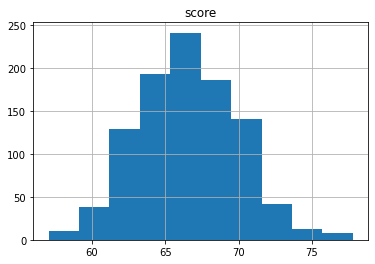

In [18]:
df.hist('score')

What if we only want uncertainty in the characterization step?

We need to modify the datapackage a bit

In [19]:
from bw_processing import load_datapackage
from fs.zipfs import ZipFS

In [20]:
database_dp = load_datapackage(ZipFS(db.filepath_processed()))
method_dp = load_datapackage(ZipFS(ipcc.filepath_processed()))

We can use the datapackages directly, just as before:

In [21]:
lca = bc.LCA(
    demand={bike.id: 1},
    data_objs=[database_dp, method_dp],
    use_distributions=True,
    seed_override=None
)
lca.lci()
lca.lcia()

In [22]:
pd.DataFrame([
    {
        'score': lca.score, 
        'inv': lca.inventory.sum(), 
        'char': lca.characterization_matrix.sum()
    } for _, _ in zip(lca, range(10))
])

,score,inv,char
0,61.622929,66.737308,0.923366
1,66.276587,66.332876,0.999151
2,70.299440,66.421915,1.058377
3,69.138496,66.122096,1.045619
4,67.735368,66.201492,1.023170
5,64.450394,66.685615,0.966481
6,69.035246,66.188051,1.043017
7,73.179753,66.858352,1.094549
8,62.491735,66.959482,0.933277
9,71.985927,66.861131,1.076648


But we can also filter out the uncertainty from the $A$ matrix:

In [23]:
database_dp.groups

{'mobility_biosphere_matrix': <bw_processing.datapackage.FilteredDatapackage at 0x21ede473fa0>,
 'mobility_inventory_geomapping_matrix': <bw_processing.datapackage.FilteredDatapackage at 0x21ede473a30>,
 'mobility_technosphere_matrix': <bw_processing.datapackage.FilteredDatapackage at 0x21ede473eb0>}

In [24]:
database_dp.get_resource('mobility_technosphere_matrix.distributions')

(array([(0,   1. , nan, nan,  nan,  nan, False),
        (0,   2.5, nan, nan,  nan,  nan, False),
        (0,   1. , nan, nan,  nan,  nan, False),
        (5, 237.3, nan, nan, 200., 300., False),
        (0,   1. , nan, nan,  nan,  nan, False)],
       dtype=[('uncertainty_type', 'u1'), ('loc', '<f4'), ('scale', '<f4'), ('shape', '<f4'), ('minimum', '<f4'), ('maximum', '<f4'), ('negative', '?')]),
 {'profile': 'data-resource',
  'format': 'npy',
  'mediatype': 'application/octet-stream',
  'name': 'mobility_technosphere_matrix.distributions',
  'matrix': 'technosphere_matrix',
  'kind': 'distributions',
  'path': 'mobility_technosphere_matrix.distributions.npy',
  'group': 'mobility_technosphere_matrix',
  'nrows': 5,
  'category': 'vector'})

In [25]:
filtered_dp = (database_dp
               .exclude_resource_group_kind('mobility_technosphere_matrix', 'distributions')
               .exclude_resource_group_kind('mobility_biosphere_matrix', 'distributions')
              )

In [26]:
[obj['name'] for obj in database_dp.resources if obj['kind'] == 'distributions']

['mobility_biosphere_matrix.distributions',
 'mobility_technosphere_matrix.distributions']

In [27]:
[obj['name'] for obj in filtered_dp.resources if obj['kind'] == 'distributions']

[]

In [28]:
lca = bc.LCA(
    {bike.id: 1},
    data_objs=[filtered_dp, method_dp],
    use_distributions=True,
    seed_override=None
)
lca.lci()
lca.lcia()

In [29]:
pd.DataFrame([
    {
        'score': lca.score, 
        'inv': lca.inventory.sum(), 
        'char': lca.characterization_matrix.sum()
    } for _, _ in zip(lca, range(10))
])

,score,inv,char
0,70.008317,66.500001,1.052757
1,66.247939,66.500001,0.996210
2,63.940854,66.500001,0.961517
3,71.740957,66.500001,1.078811
4,64.390743,66.500001,0.968282
5,70.606941,66.500001,1.061758
6,67.231154,66.500001,1.010995
7,65.317662,66.500001,0.982220
8,61.085454,66.500001,0.918578
9,72.546846,66.500001,1.090930


We have a problem in our modelling. Maybe you spotted it already; in any case, we can see this LCI data in a document. This is the third perspective, and so we need to use our third library: `bw2io`.

In [34]:
from bw2io.export import write_lci_excel

In [35]:
from pathlib import Path

In [38]:
xl = Path(write_lci_excel(db.name))

In [39]:
xl.rename(Path.cwd() / xl.name)

WindowsPath('C:/Users/fabic/lci-mobility.xlsx')

In [40]:
bi.create_core_migrations()

In [49]:
xl_importer.strategies

[<function bw2io.strategies.csv.csv_restore_tuples(data)>,
 <function bw2io.strategies.csv.csv_restore_booleans(data)>,
 <function bw2io.strategies.csv.csv_numerize(data)>,
 <function bw2io.strategies.csv.csv_drop_unknown(data)>,
 <function bw2io.strategies.csv.csv_add_missing_exchanges_section(data)>,
 <function bw2io.strategies.generic.normalize_units(db)>,
 <function bw2io.strategies.biosphere.normalize_biosphere_categories(db, lcia=False)>,
 <function bw2io.strategies.biosphere.normalize_biosphere_names(db, lcia=False)>,
 <function bw2io.strategies.biosphere.strip_biosphere_exc_locations(db)>,
 <function bw2io.strategies.generic.set_code_by_activity_hash(db, overwrite=False)>,
 functools.partial(<function link_iterable_by_fields at 0x0000021EDC778A60>, other=Brightway2 SQLiteBackend: biosphere3, kind='biosphere'),
 <function bw2io.strategies.generic.assign_only_product_as_production(db)>,
 <function bw2io.strategies.generic.link_technosphere_by_activity_hash(db, external_db_name=No

In [41]:
xl_importer = bi.ExcelImporter("lci-mobility2.xlsx")

Extracted 1 worksheets in 0.01 seconds


In [42]:
xl_importer.apply_strategies()

Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.01 seconds


In [43]:
xl_importer.statistics()

3 datasets
3 exchanges
1 unlinked exchanges
  Type biosphere: 1 unique unlinked exchanges


(3, 3, 1)

In [44]:
for obj in xl_importer.unlinked:
    print(obj)

{'name': 'Carbon Dioxide', 'amount': 0.11209439528023599, 'categories': ('air',), 'type': 'biosphere', 'minimum': 0.1, 'maximum': 0.12, 'uncertainty_type': 5}


In [45]:
co2

'Carbon Dioxide' (None, GLO, ('air',))

In [50]:
co2['name'] == obj['name']  # the name was the same

True

In [46]:
xl_importer.match_database("biosphere", fields=['name'])

Applying strategy: link_iterable_by_fields


In [47]:
xl_importer.statistics()

3 datasets
3 exchanges
0 unlinked exchanges
  


(3, 3, 0)

In [52]:
xl_importer.all_linked

3 datasets
3 exchanges
0 unlinked exchanges
  


True

In [48]:
xl_importer.write_database()

Writing activities to SQLite3 database:
0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 10/19/2021 10:40:02
  Finished: 10/19/2021 10:40:02
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 0.60
Created database: mobility
